# Experiments

Usually, when working with random boolean netwokrs, one is interested the average behaviour for a particular range of parameters. Performing such calculations naively, as we did previously, can and will lead to large computation times in most cases. Therefore, we added support for desining and running large experiments in parallel with Ray. This experiments can be run with a cluster without major problems thanks to Ray great flexibility. All the elements neccesary are contained in the execution module (ray must be installed independently).import pybn.execution as execution

In [1]:
import pybn.execution as execution
from pybn.networks import BooleanNetwork
from pybn.graphs import uniform_graph
from pybn.observers import EntropyObserver

# Designing an experiment

The first thing we need to do is to design an experiment. This is done with via one dictionary and one custom iterator.

A reference dictionary to build experiments can be obtained through the new_configuration method. The configuration dictionary is used to declare the STATIC parameters of the experiment.

In [2]:
execution.new_configuration()

{'network': {'class': None, 'seed': None},
 'graph': {'function': None, 'seed': None},
 'fuzzy': {'conjunction': <function pybn.execution.new_configuration.<locals>.<lambda>(x, y)>,
  'disjunction': <function pybn.execution.new_configuration.<locals>.<lambda>(x, y)>,
  'negation': <function pybn.execution.new_configuration.<locals>.<lambda>(x)>},
 'parameters': {'nodes': 0,
  'k': 0,
  'w': 0,
  'base': 0,
  'bias': 0.5,
  'steps': 0,
  'transient': 0},
 'summary': {'per_node': False, 'precision': 6},
 'execution': {'networks': 0, 'samples': 0},
 'observers': [],
 'storage_path': './'}

Let's create a new experiment. Notice that you do not need to define every single parameter that comes with the configuration dictionary, only the ones you will use. Within the parameters subdirectory we will introduce the inputs to the graph functions, we have reserved the letters k and w for our predefined functions but if you define any custom graph function the inputs for such function must be introduced inside this subdirectory. For this particular case (uniform_graph) k means the average connectivity of the network. Although this may seem confusing at first it keeps the overall workflow simple.

In [3]:
configuration = {
        'network': {'class': BooleanNetwork},
        'graph': {'function': uniform_graph},
        'parameters': {'nodes': 32, 'k':0, 'base': 2, 'bias': 0.5, 'steps': 128, 'transient': 0},
        'summary':{'per_node': True, 'precision': 6},
        'execution': {'networks': 100, 'samples': 100},
        'observers': [EntropyObserver],
        'storage_path' : './Exp'
    }

The Execution Iterator is a custom iterator used to declare all VARIABLE parameters of the experiment.
This iterator overwrites the configuration dictionary each timestep within the execution function.

In [4]:
iterator = execution.ExecutionIterator()

Each target variable must be declared explicitly and the name must be the same that the configuration dictionary uses.

In [5]:
import numpy as np

bias_values = np.arange(0,1.01,0.2)
iterator.register_variable('bias', bias_values)

connectivity_values = np.arange(0,3.01,0.1)
iterator.register_variable('k', connectivity_values)

It is important to notice that all static parameters will become variables if we declare it within the iterator. For example,

In [6]:
#iterator.register_variable('nodes', range(16,65))

will produce an experiment that variates the nodes from 16 to 64 even though we declared nodes  = 32 previously.

The iterator also accepts custom lists. For instance,

In [7]:
#iterator.register_variable('basis', [2,3,5,7,11,13])

The iterator also accepts a list of particular graphs to test.

In [8]:
#iterator.register_variable('graph', [graph1, graph2])

Or a list of graphs functions.

In [9]:
#iterator.register_variable('graph_function', [graph_function1, graph_function2])

Only 'graph' or 'graph_function' may be declared at a time.

# Dispatching an experiment

Dispatching an experiment its easy. To run the experiment one just need to call the function run_experiment, with the configuration and the iterator.

In [10]:
execution.run_experiment(configuration, iterator)

2021-06-11 14:51:58,167	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


The data is stored with a timestamp in the specified location.

# Extracting data from an experiment

For the sake of simplicity consider the case in which we are interested in computing a plot of the entropy vs connectivity for each one of the basis. The first thing we need to to is to locate the path to the stored data.

In [11]:
folder_path = 'folder_path/day\\month\\year_hour:minute:seconds'
#example_folder_path = './Exp/11\\06\\21_13:34:05'
folder_path = './Exp/11\\06\\21_14:51:59'

The next step is to identify how the observer named those files. In our case the name is 'entropy' but these tags can be consulted with 'observer.observations'.

In [12]:
observer_tag = 'entropy'

The next piece of information we require is a list of all the stamps used to distinguish between each set of parameters used in the experiment. Fortunately, the iterator comes with an utily that returns all the information we need. Observe that get_stamp_list returns an array of the same shape as the iterator which facilitates extracting the information.

In [13]:
file_stamps = iterator.get_stamp_list()

In [14]:
iterator.shape() == file_stamps.shape

True

To illustrate how to read the data, we read the per_node entropy for the previous experiment. Reading each file will return several rows (one per each network) and several columns (one per each node). Each entry will contain the average entropy calculated for that particular node (similarly with the other type of observers). For simplicity we will just compute the average entropy of each network (average of the entropy of each node) and again we will compute the average among different realizations (which turns out to be the mean of the array). We will end up with an average entropy per combination of parameters.

In [15]:
from pybn.functions import read_file
import os

mean_data = np.zeros(iterator.shape())
for basis in range(file_stamps.shape[0]):
    for connectivity in range(file_stamps.shape[1]):
        file_name = observer_tag + '_' + file_stamps[basis, connectivity]
        path = os.path.join(folder_path, file_name)
        mean = np.mean(read_file(path, std=False))
        mean_data[basis, connectivity] = mean

In [16]:
mean_data.shape

(6, 31)

Finally, we plot the entropy against the connectivity.

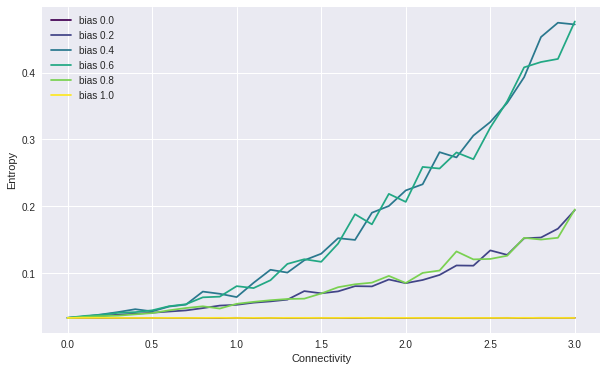

In [17]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
plt.style.use('seaborn')

fig = plt.figure(figsize=(10,6))
colors = pl.cm.viridis(np.linspace(0,1,len(bias_values)))
for i in range(len(bias_values)):
    plt.plot(connectivity_values, mean_data[i], label=('bias %.1f'%(bias_values[i])), color=colors[i])
plt.xlabel('Connectivity')
plt.ylabel('Entropy')
plt.legend()